# 1. Set-up

Connect to the UN Global Platform and use kernel `pyspark3.5 ais2.9`Connect to the UN Global Platform and use kernel `pyspark3.5 ais2.9`

# Initialize 

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping, Point, Polygon
from pyspark.sql import functions as F
from pyspark.sql import Window as W
from ais import functions as af
import h3.api.numpy_int as h3int

import matplotlib.pyplot as plt
import folium

import os
import pyproj

generated new fontManager


In [2]:
raw_ais_save_path = os.environ["USER_TEMP_S3PATH"] + f"cherryl/ais_passageways/global_cape/ais/"

# Determining POI for Cape of Good Hope

## Large Buffer Area around Cape of Good Hope

In [3]:
#Point at tip of Cape of Good Hope from Google Maps
lat = -33.916667
long = 18.416667

h3_res=1
epsg_from = 4326

# Transformation for South Africa: http://epsg.io/9221
epsg_to = 9221

buffer_dist_km = 1000

In [4]:
#Create a geodataframe with the Cape of Good Hope location as geometry
gdf = gpd.GeoDataFrame([[Point(long,lat)]], columns=['location'], crs=epsg_from, geometry='location')

#Create a 1000KM distance around the location, covering a square area
gdf['buffer'] = gdf[['location']].to_crs(epsg_to).buffer(buffer_dist_km * 1000, cap_style="square").to_crs(epsg_from)
gdf = gdf.set_geometry('buffer')


H3 count:2483


<Axes: >

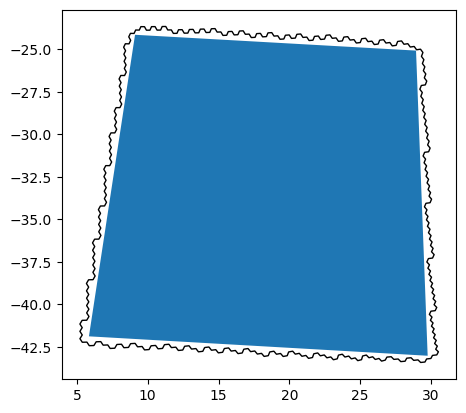

In [5]:
h3_resolution = 4

inputs = [('Buffer', mapping(gdf['buffer'].iloc[0]))]
hex_df = af.polygon_to_hex_df(inputs, h3_resolution, overfill=True)
hexes = hex_df['hex_id'].drop_duplicates().tolist()

print(f"\nH3 count:{len(hexes)}")
hexes = hex_df['hex_id'].drop_duplicates().tolist()
h3_gdf = gpd.GeoDataFrame([["H3",Polygon(h3int.h3_set_to_multi_polygon(hexes, geo_json=True)[0][0])]], columns=['h3','geometry'], crs=4326)
fig, ax = plt.subplots()
gdf.plot(ax=ax)
h3_gdf.plot(ax=ax, facecolor="none")

## Determine AIS Concentration

In [6]:
sdf = af.get_ais(spark, start_date="2021-03-23",end_date="2021-04-30",h3_list = hexes).cache()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


Closing down clientserver connection


In [11]:
# freq = {}
# for i in range(0,6):
#     # print(i)
#     freq[i] = sdf.groupBy(f'H3_int_index_{i}').count().toPandas()

In [12]:
sdf.unpersist()

DataFrame[H3_int_index_4: bigint, message_type: int, mmsi: int, dt_insert_utc: timestamp, longitude: double, latitude: double, imo: int, vessel_name: string, callsign: string, vessel_type: string, vessel_type_code: int, vessel_type_cargo: string, vessel_class: string, length: double, width: double, flag_country: string, flag_code: int, destination: string, eta: int, draught: double, sog: double, cog: double, rot: double, heading: double, nav_status: string, nav_status_code: int, source: string, dt_pos_utc: timestamp, dt_static_utc: timestamp, vessel_type_main: string, vessel_type_sub: string, eeid: bigint, source_filename: string, H3index_0: string, H3_int_index_0: bigint, H3_int_index_1: bigint, H3_int_index_2: bigint, H3_int_index_3: bigint, H3_int_index_5: bigint, H3_int_index_6: bigint, H3_int_index_7: bigint, H3_int_index_8: bigint, H3_int_index_9: bigint, H3_int_index_10: bigint, H3_int_index_11: bigint, H3_int_index_12: bigint, H3_int_index_13: bigint, H3_int_index_14: bigint, H

In [13]:
df = pd.concat([pd.DataFrame(freq[i]).assign(h3_res=i) \
                .sort_values('count',ascending=False,ignore_index=True) \
                .rename(columns={'count':f'H3_res_{i}_freq'})[[f'H3_res_{i}_freq']]
                for i in range(0,6)], axis=1)
n = df.sum().iloc[0]

print(f"% of Top 5 indices per resolution (n={n:,})")
(df/n * 100).iloc[:5]

% of Top 5 indices per resolution (n=23,967,018.0)


,H3_res_0_freq,H3_res_1_freq,H3_res_2_freq,H3_res_3_freq,H3_res_4_freq,H3_res_5_freq
0,49.056165,34.175866,19.502747,8.200490,6.365231,5.378062
1,43.672100,34.018396,14.448235,3.999918,3.182645,1.488124
2,7.271735,8.843253,11.635035,3.916649,1.596185,1.271072
3,NaN,6.328998,5.539279,3.540274,1.123590,1.004885
4,NaN,4.741967,5.019244,3.351890,1.040993,0.779354


In [14]:
print("No. of Unique Indices")
df.count()

No. of Unique Indices


H3_res_0_freq        3
H3_res_1_freq       14
H3_res_2_freq       62
H3_res_3_freq      328
H3_res_4_freq     1731
H3_res_5_freq    10965
dtype: int64

## Cape POI

In [23]:
h3_cape = list(h3int.k_ring(freq[3].sort_values(['count'], ascending=False).iloc[0]['H3_int_index_3'],1))
h3_cape = [int(x) for x in h3_cape]
h3_cape

[593018778942439423,
 593286303865372671,
 593284242281070591,
 593018504064532479,
 593018366625579007,
 593018641503485951,
 593286166426419199]

## Visualize

# Cargo-related Vessels that Passed Cape starting the Blockage Period

In [24]:
#Read Ship Register datasets as a spark dataframe, use version 20210609 which is the earliest version available in UNGP
#note that af module is from the ais package 

#The ShipData table provides information on the vessel's IMO, vessel type described by the StatCode5 and ShiptypeLevel5
ihs = af.read_ihs_table(spark, "ShipData.CSV", version="20210609") \
.select("ShipName","LRIMOShipNo","MaritimeMobileServiceIdentityMMSINumber","StatCode5","ShiptypeLevel5")

#We use the tblShipTypeCodes table to get more information on the vessel type.
#We select only "Cargo-carrying vessels" which is identified by ShiptypeLevel2 information
ihs_statcode = af.read_ihs_table(spark, "tblShipTypeCodes.CSV",  version="20210609") \
.select("StatCode5","ShiptypeLevel2") \
.filter(F.col("ShiptypeLevel2").isin(["Bulk Carriers", "Dry Cargo/Passenger", "Tankers"]))

In [25]:
vessel_list = af.get_ais(spark, start_date="2021-03-23",end_date="2021-04-30",h3_list = h3_cape, columns=['imo']) \
.distinct() \
.join(ihs.withColumnRenamed("LRIMOShipNo","imo"), how="inner", on=['imo']) \
.join(ihs_statcode, how="inner", on=['StatCode5']) \
.select("imo", "ShipName","MaritimeMobileServiceIdentityMMSINumber","StatCode5","ShiptypeLevel5","ShiptypeLevel2") \
.cache()

In [26]:
vessel_list.count()

1993

# Vessel Routes

In [29]:
ais_cols = [
    'mmsi',
    'imo',
    'vessel_name',
    'longitude',
    'latitude',
    'dt_pos_utc',
    'destination',
    'sog',
    'heading',
    'draught',
    'vessel_type',
    'H3_int_index_1',
    'H3_int_index_0'
]

In [30]:
sdf = af.get_ais(spark, "2021-03-14","2021-04-30", columns=ais_cols) \
.join(vessel_list, on=['imo'], how="inner")

In [31]:
n = sdf.count()
print(f"Count of AIS Messages from the Vessel List: {n:,}")

Count of AIS Messages from the Vessel List: 71,218,368


In [32]:
#assign grouping per h3 path
sdf_route_group = af.assign_route(sdf,['imo'], ['dt_pos_utc'], 'H3_int_index_1')

In [33]:
#summarize routes according to H3 path
sdf_route_h3 = sdf_route_group.groupby('imo', 'route_group').agg( 
        F.min('dt_pos_utc').alias('min_date'),
        F.max('dt_pos_utc').alias('max_date'),
        F.count('mmsi').alias('count_obs'),
        F.min('draught').alias('min_draught'),
        F.max('draught').alias('max_draught'),
        F.min_by("heading","dt_pos_utc").alias("heading"),
        F.min_by("sog","dt_pos_utc").alias("sog"),
        F.min_by("latitude","dt_pos_utc").alias("latitude"),
        F.min_by("longitude","dt_pos_utc").alias("longitude"),
        F.min_by("H3_int_index_1","dt_pos_utc").alias("H3_int_index_1"),
        F.min_by("H3_int_index_0","dt_pos_utc").alias("H3_int_index_0"),
        F.first("vessel_name").alias("vessel_name"),
        F.first("vessel_type").alias("vessel_type"),
        F.first("ShipName").alias("ShipName"),
        F.first("StatCode5").alias("StatCode5"),
        F.first("ShiptypeLevel5").alias("ShiptypeLevel5"),
        F.first("ShiptypeLevel2").alias("ShiptypeLevel2"),
        F.collect_set("destination").alias("destination_list")
        )

In [34]:
sdf_route_h3.count()

92106

In [35]:
sdf_route_h3.write.mode("overwrite").parquet(raw_ais_save_path)

# Identify Reroutes

In [3]:
df = pd.read_parquet(raw_ais_save_path) \
[['imo','vessel_name','ShiptypeLevel2','ShiptypeLevel5','route_group','min_date','count_obs','latitude','longitude','H3_int_index_0','destination_list']] \
.rename(columns={"route_group":'h3_path'}) \
.sort_values(["imo","h3_path"], ignore_index=True)
df.info()
df.head()

Found credentials from IAM Role: eksctl-sparky-mc-sparkface-nodegr-NodeInstanceRole-15Y58CLME2WUS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92082 entries, 0 to 92081
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   imo               92082 non-null  int32         
 1   vessel_name       92082 non-null  object        
 2   ShiptypeLevel2    92082 non-null  object        
 3   ShiptypeLevel5    92082 non-null  object        
 4   h3_path           92082 non-null  int64         
 5   min_date          92082 non-null  datetime64[ns]
 6   count_obs         92082 non-null  int64         
 7   latitude          92082 non-null  float64       
 8   longitude         92082 non-null  float64       
 9   H3_int_index_0    92082 non-null  int64         
 10  destination_list  92082 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), int64(3), object(4)
memory usage: 7.4+ MB


,imo,vessel_name,ShiptypeLevel2,ShiptypeLevel5,h3_path,min_date,count_obs,latitude,longitude,H3_int_index_0,destination_list
0,8311106,ICE ROSE,Dry Cargo/Passenger,Refrigerated Cargo Ship,0,2021-03-14 00:19:18,199,8.030512,-79.362512,578290339652042751,"[EC GYE, BALBOA, GI GIB]"
1,8311106,ICE ROSE,Dry Cargo/Passenger,Refrigerated Cargo Ship,1,2021-03-15 11:20:25,3,9.905588,-79.407638,578290339652042751,[GI GIB]
2,8311106,ICE ROSE,Dry Cargo/Passenger,Refrigerated Cargo Ship,2,2021-03-15 17:24:17,2,10.827527,-78.151535,578290339652042751,[GI GIB]
3,8311106,ICE ROSE,Dry Cargo/Passenger,Refrigerated Cargo Ship,3,2021-03-16 00:47:59,2,12.270542,-77.233898,578290339652042751,[GI GIB]
4,8311106,ICE ROSE,Dry Cargo/Passenger,Refrigerated Cargo Ship,4,2021-03-16 11:03:36,3,14.655548,-76.315167,578290339652042751,[GI GIB]


## Captured Point of Reroute

In [4]:
df["blockage"] = (df['min_date'] >= "2021-03-22") & (df['min_date'] < "2021-04-10")

In [5]:
#recalculate heading
geodesic = pyproj.Geod(ellps='WGS84')
df[['lat1','long1']] = df.groupby('imo')[['latitude','longitude']].shift()
df['heading_calc'] = df[['long1','lat1','longitude','latitude']].apply(lambda x: geodesic.inv(x[0],x[1],x[2],x[3])[0], axis=1)

df['heading_calc_abs'] = abs(df.heading_calc)
df['heading_calc_abs_diff'] = df.groupby('imo').heading_calc_abs.diff()
df['heading_calc_diff'] = abs(df.groupby('imo').heading_calc.diff())

cond = (df.heading_calc_diff>=180)
df.loc[cond,"heading_calc_diff"] = 360 - df.loc[cond,"heading_calc_diff"] 

df['heading_calc_turn'] = df.heading_calc_diff > 15

df['heading_calc_ns'] = df.heading_calc_abs > 90
df['heading_calc_we'] = df.heading_calc > 0

In [6]:
#regions of reroute

#North Atlantic
lat_long = [32.80880932967446, -54.558228145582056]
north_atlantic = h3int.k_ring(h3int.geo_to_h3(*lat_long, 0),1)
df['north_atlantic'] = df.H3_int_index_0.isin(north_atlantic)

#Arabian Sea
lat_long = [12.66617941262643, 64.2973173192955]
arabian= h3int.k_ring(h3int.geo_to_h3(*lat_long, 0),1)
df['arabian'] = df.H3_int_index_0.isin(arabian)

#Near Suez Canal
lat_long = [36.313572, -3.517402]
near_suez = [x for x in list(h3int.k_ring(h3int.geo_to_h3(36.313572, -3.517402,0),1)) \
               if x not in north_atlantic.tolist() + [577973680303243263,578044049047420927] ]
df['near_suez'] = df.H3_int_index_0.isin(near_suez)

#Indian Ocean
lat_long = [-15.044354, 87.352963]
indian_ocean = [x for x in list(h3int.k_ring(h3int.geo_to_h3(*lat_long,0),1)) if (x not in arabian.tolist() + [579486608303063039, 579556977047240703])]
df['indian_ocean'] = df.H3_int_index_0.isin(indian_ocean)

In [7]:
df["reroute_point"] =  df['heading_calc_ns'] &  (df['north_atlantic'] | df['arabian'] | df['indian_ocean'] | df['near_suez']) &  df['blockage']  &  df['heading_calc_turn'] 

## Captured Suez as Destination

In [8]:
def check_suez_dest(a):
    for dest in a:
        for word in ['SUEZ', 'SZC','SUZ','PSD','SUC','EGYPT','EG','SAID']:
            if word in dest:
                return True
    return False

In [9]:
df['destination_suez'] = df['destination_list'].apply(lambda x: check_suez_dest(x)) & df['blockage']

In [8]:
df_agg = df[df['reroute_point'] | df['destination_suez']].groupby('imo').agg({'reroute_point':'max', 'destination_suez':'max','north_atlantic':'max','arabian':'max','indian_ocean':'max','near_suez':'max'})

In [9]:
print(f"Vessels for manual validation: {df_agg[df_agg['reroute_point'] | df_agg['destination_suez']].shape[0]:,}")

Vessels for manual validation: 772


In [10]:
df_agg.shape

(772, 6)

# Manual validation

In [19]:
def base_map (lat_long, zoom_start=3):
    m = folium.Map(lat_long,zoom_start=zoom_start, tiles='cartodbpositron', name="Base")
    folium.CircleMarker([-33.9095, 18.4356], color="black", radius=7, fill=True,fill_color="gold", fill_opacity=1).add_to(m) 
    folium.Marker([-33.9095, 18.4356],icon=folium.DivIcon(icon_size=(150,36),icon_anchor=(50,25),
                    html='<div style="font-size: 10pt; color:black" ><b>%s</b></div>' % "Cape Town")).add_to(m)

    folium.CircleMarker([30.49474, 32.34467], color="black", radius=7, fill=True,fill_color="gold", fill_opacity=1).add_to(m) 
    folium.Marker([30.49474, 32.34467],icon=folium.DivIcon(icon_size=(150,36),icon_anchor=(50,25),
                    html='<div style="font-size: 10pt; color:black" ><b>%s</b></div>' % "Suez Canal")).add_to(m)

    return m

In [26]:
def map_route(chosen,color):
    m = folium.FeatureGroup(name=str(chosen), show=False)
    
    def popup(a):
        return (
        "Date: {date}<br>"
        "Destination: {dest}<br>"
        "Vessel: {vessel_name} <br>"
        "IMO: {imo} <br>"
        "Vessel Type: {vessel_type} <br>"
               ).format(date=a.min_date.strftime("%Y-%m-%d"),
                dest=a.destination_list,
                vessel_name=a.vessel_name,
                imo = a.imo,
                vessel_type = a.ShiptypeLevel2 + "-" + a.ShiptypeLevel5
               )

    a  = df[df['imo']==chosen]
    geojson = {"type": 'FeatureCollection',
           "features": [{ "type": "Feature",
                        "geometry": {"type":"Point",
                                     "coordinates": [a.iloc[i].longitude, a.iloc[i].latitude]
                                    },
                        "properties": { "Date": a.iloc[i].min_date.strftime("%Y-%m-%d"),
                                       "Destination": str(a.iloc[i].destination_list),
                                       "Vessel": a.iloc[i].vessel_name,
                                       "IMO": str(a.iloc[i].imo),
                                       "Vessel Type":a.iloc[i].ShiptypeLevel2 + "-" + a.iloc[i].ShiptypeLevel5    
                                      }, 
                       } for i in range(a.shape[0])]
           }
    
    #Route Tooltip
    folium.GeoJson(geojson,
                   marker=folium.CircleMarker(radius=3, color=color, fill=True, fill_color=color, fill_opacity=0.9), 
                   tooltip=folium.GeoJsonTooltip(fields=['Date','Destination','Vessel','IMO',"Vessel Type"])).add_to(m)

    
    #Route
    folium.PolyLine(a[['latitude','longitude']].values,
                    color=color, weight=5, opacity=0.5).add_to(m)
    
    #Flag blockage
    a = df[(df.imo==chosen) & (df.blockage)].iloc[0]
    lat_long = a[['latitude','longitude']].tolist()
    folium.CircleMarker(lat_long, color="black", radius=7, fill=True,fill_color="red", fill_opacity=1).add_to(m) 
    # folium.Marker(lat_long,tooltip=popup(a), 
    #         icon=folium.DivIcon(icon_size=(150,36),icon_anchor=(50,25),
    #             html='<div style="font-size: 10pt; color:black" ><b>%s</b></div>' % "Start Blockage")).add_to(m)

    #Flag start
    a = df[(df.imo==chosen)].iloc[0]
    lat_long = a[['latitude','longitude']].tolist()
    date = a.min_date.strftime("%Y-%m-%d")
    folium.CircleMarker(lat_long, color="black", radius=5, fill=True,fill_color="white", fill_opacity=1).add_to(m) 
    # folium.Marker(lat_long,tooltip=popup(a), 
    #         icon=folium.DivIcon(icon_size=(150,36),icon_anchor=(50,25),
    #             html='<div style="font-size: 10pt; color:black" ><b>%s</b></div>' % date)).add_to(m)

    #Flag end
    a = df[(df.imo==chosen)].iloc[-1]
    lat_long = a[['latitude','longitude']].tolist()
    date = a.min_date.strftime("%Y-%m-%d")
    folium.CircleMarker(lat_long, color="black", radius=5, fill=True,fill_color="white", fill_opacity=1).add_to(m) 
    # folium.Marker(lat_long,tooltip=popup(a),
    #         icon=folium.DivIcon(icon_size=(150,36),icon_anchor=(50,25),
    #             html='<div style="font-size: 10pt; color:black" ><b>%s</b></div>' % date)).add_to(m)
    
    #Reroute
    try:
        b = df[(df.imo==chosen) &  df.reroute_point]
        for i in range(b.shape[0]):
            a = df[(df.imo==chosen) &  df.reroute_point].iloc[i]
            lat_long = a[['latitude','longitude']].tolist()
            folium.CircleMarker(lat_long, color="black", radius=5, fill=True,fill_color="aqua", fill_opacity=1).add_to(m) 
            # folium.Marker(lat_long,
            #               tooltip=popup(a) + \
            #                             "Heading Diff: {heading} <br>".format(heading = str(round(a.heading_calc_diff)) + u'\N{DEGREE SIGN}'),
            #               icon=folium.DivIcon(icon_size=(150,36),icon_anchor=(50,25),
            #                         html='<div style="font-size: 10pt; color:black" ><b>%s</b></div>' % "Reroute"
            #             )).add_to(m)
    except:
        None
        
    return m

In [21]:
def download_map(m, filename="map.html", title="map.html"):
    #m is folium map    
    import base64  
    from IPython.display import display, HTML
    html_string = m.get_root().render()
    b64 = base64.b64encode(html_string.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'   
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [11]:
imo_list = df[df['imo'].isin(df_agg[df_agg['destination_suez'] | df_agg['reroute_point']].index)].groupby("imo").size().sort_index()
len(imo_list.index)

772

In [55]:
#to set initial zoom
imo=imo_list.index[0]
lat_long = df[(df['imo']==imo) & (df['blockage'])][['latitude','longitude']].iloc[0].tolist()

f = folium.Figure(width=1000, height=800)
m = base_map(lat_long)

# # #region polygon
# # a = folium.GeoJson(north_atlantic_poly, name="North Atlantic").add_to(m)

#map each mmsi
#check per 100, change the cut-offs
for i in imo_list.index[300:400]:
    chosen = i
    a=map_route(chosen,'purple').add_to(m)
a = folium.LayerControl().add_to(m)
m.add_to(f)
f

In [12]:
verified_reroute = [9225342,
9290476,
9293753,
9301495,
9321536,
9342528,
9359026,
9388821,
9397315,
9399208,
9431135,
9431147,
9432165,
9433793,
9450387,
9475612,
9508316,
9597331,
9604017,
9619957,
9620683,
9625528,
9628128,
9629108,
9629586,
9632129,
9632143,
9684665,
9692818,
9700964,
9722429,
9740457,
9776200,
9786827,
9832729,
9835173,
9835836,
9850692,
9858486,
9863314,
9868338,
9868352,
9591181,
9731169,
9810379,
9750232,
9342827,
9847413
]

In [13]:
df['Remarks'] = ""
cond = df['imo'].isin(verified_reroute)
df.loc[cond,"Remarks"] = "Verified Reroute"
df.loc[~cond & df['imo'].isin(imo_list), "Remarks"] = "Not Reroute"

In [14]:
df_agg['verified_reroute'] = df_agg.index.isin(verified_reroute)

In [36]:
df_agg["Route"] = "na"
cond = df_agg['verified_reroute'] & (df_agg['north_atlantic'] | df_agg['near_suez']) & ~df_agg['arabian'] & ~df_agg['indian_ocean'] 
df_agg.loc[cond, "Route"] = "West - East"

cond = df_agg['verified_reroute'] & ~df_agg['north_atlantic'] & (df_agg['arabian']  | df_agg['indian_ocean']) 
df_agg.loc[cond, "Route"] = "East - West"

europe_dest = [
9431135,
9431147,
9620683,
9625528,
9786827,
9850692,
9863314,
9868338
]
df_agg.loc[df_agg.index.isin(europe_dest), "Route"] = "To/From Europe"

In [37]:
df_agg.pivot_table(index=['destination_suez','reroute_point'], columns=['verified_reroute','Route'], aggfunc="size")

verified_reroute                False       True                            
Route                              na East - West To/From Europe West - East
destination_suez reroute_point                                              
False            True           694.0         1.0            NaN         5.0
True             False           16.0         NaN            NaN         NaN
                 True            14.0        20.0            8.0        14.0

In [45]:
df['Route'] = df['imo'].map(df_agg[df_agg['verified_reroute']]['Route'])

# Save Outputs

In [43]:
#to set initial zoom
chosen_df = df_agg[df_agg['Route']=="West - East"]
imo=chosen_df.index[0]
lat_long = df[(df['imo']==imo) & (df['blockage'])][['latitude','longitude']].iloc[0].tolist()

f = folium.Figure(width=1000, height=500)
m = base_map(lat_long)

#map each mmsi
#check per 100, change the cut-offs
for i in chosen_df.index:
    chosen = i
    a=map_route(chosen,'purple').add_to(m)
a = folium.LayerControl().add_to(m)
m.add_to(f)
f

In [44]:
download_map(f,filename="Suez Canal Reroute West - East.html", title="Suez Canal Reroute West - East.html")

In [46]:
df.to_pickle(raw_ais_save_path[:-4] + "Reroute.pkl")

In [47]:
verified_reroute_df = df[df['imo'].isin(verified_reroute)][['imo','vessel_name','ShiptypeLevel2','ShiptypeLevel5','Route']].drop_duplicates(subset=['imo']).reset_index(drop=True)

In [48]:
af.create_download_link(verified_reroute_df, "Verified Reroute.csv", "Verified Reroute.csv")